# Feedback Focus

In this notebook, we aim to analyze customer reviews to better understand their sentiment and how it impacts the perception of our brand. By applying Natural Language Processing (NLP) techniques and machine learning models, we will classify reviews into categories of positive, neutral, and negative sentiments.

We will also address the following business questions:

- **What is the overall sentiment of customer reviews, and how does it impact our brand perception?**
- **What specific actions can we take to address neutral and negative feedback while capitalizing on positive reviews?**

The insights gained from this analysis will help inform strategies to improve customer experience and satisfaction, as well as enhance brand reputation.

## Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import standard libraries
import os
import re
import string
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import text processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Import machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score, 
    recall_score, precision_score, f1_score
)

from tqdm import tqdm

from modules.constants import *

## Data Loading

In [2]:
tbl_labelled_review = pd.read_csv(TBL_LABELLED_REVIEWS_PATH)
tbl_customer_review = pd.read_csv(TBL_CUSTOMER_REVIEWS_PATH)

# Commento: Visualizzare le prime righe dei dataset per avere un'idea del contenuto
print("Labelled Review Dataset")
print(tbl_labelled_review.head())

print("\nCustomer Review Dataset")
print(tbl_customer_review.head())


Labelled Review Dataset
   labelled_reviews_index                                        review_text  \
0                       0  I'm no bitters expert but I bought it as a gif...   
1                       1  these are probably great in the right drinks, ...   
2                       2  I sent these to my dad for his bday and he sai...   
3                       3  I purchased these as a gift for family member ...   
4                       4  My wife bought me this sauce sampler for Chris...   

  sentiment_label  
0         neutral  
1         neutral  
2        positive  
3        positive  
4         neutral  

Customer Review Dataset
   review_id  customer_id                                        review_text
0          1       814256  I have bought several of the Vitality canned d...
1          2       457475  Product arrived labeled as Jumbo Salted Peanut...
2          3       104045  This is a confection that has been around a fe...
3          4       603662  If you are look

## Exploratory Data Analysis (Reviews)

In [3]:
# Commento: Verificare la presenza di valori nulli nei dataset
print("Valori nulli in tbl_labelled_review")
print(tbl_labelled_review.isnull().sum())

print("\nValori nulli in tbl_customer_review")
print(tbl_customer_review.isnull().sum())


Valori nulli in tbl_labelled_review
labelled_reviews_index    0
review_text               0
sentiment_label           0
dtype: int64

Valori nulli in tbl_customer_review
review_id      0
customer_id    0
review_text    0
dtype: int64


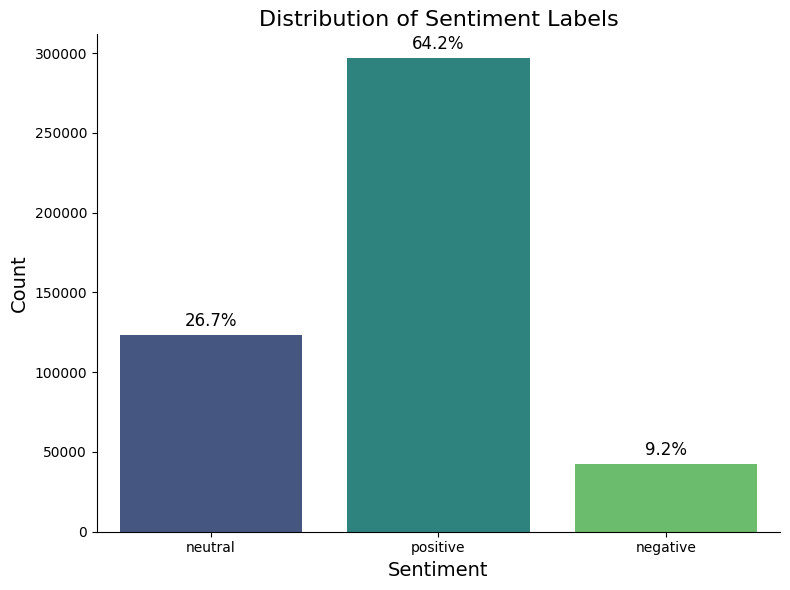

In [4]:

# Calculate the distribution of sentiment labels
sentiment_counts = tbl_labelled_review['sentiment_label'].value_counts()
total = sentiment_counts.sum()

# Create the plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment_label', data=tbl_labelled_review, palette='viridis')
plt.title('Distribution of Sentiment Labels', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add annotations with percentages
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Clean up the plot for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()


This chart displays the distribution of sentiment labels within the customer reviews. It shows that a substantial majority, 64.2%, of the feedback is positive, reflecting a high level of customer satisfaction. On the other hand, neutral sentiments represent 26.7% of the reviews, while negative sentiments account for 9.2%. This visualization helps highlight the predominant positive perception among our customers, alongside the lesser, yet significant, portions of neutral and negative feedback.


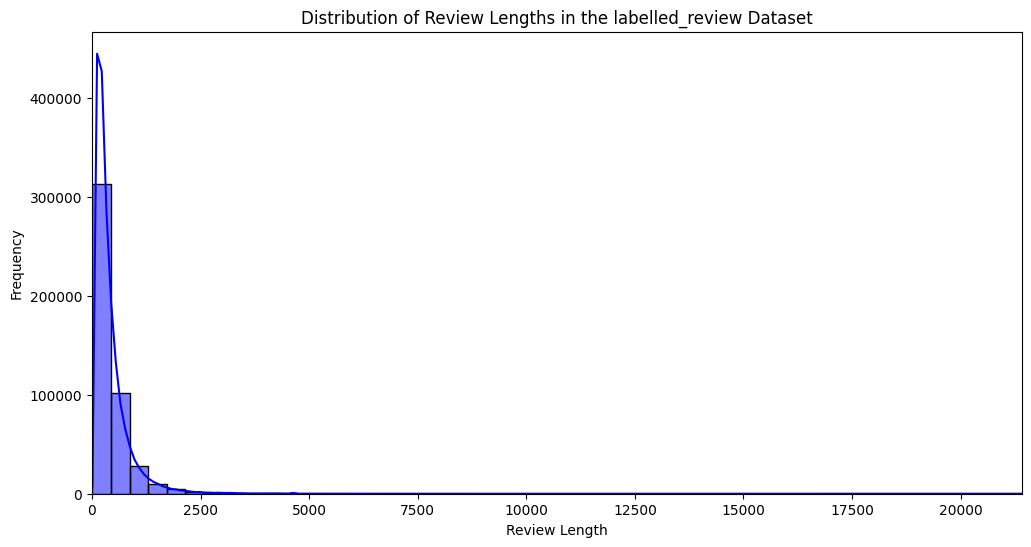

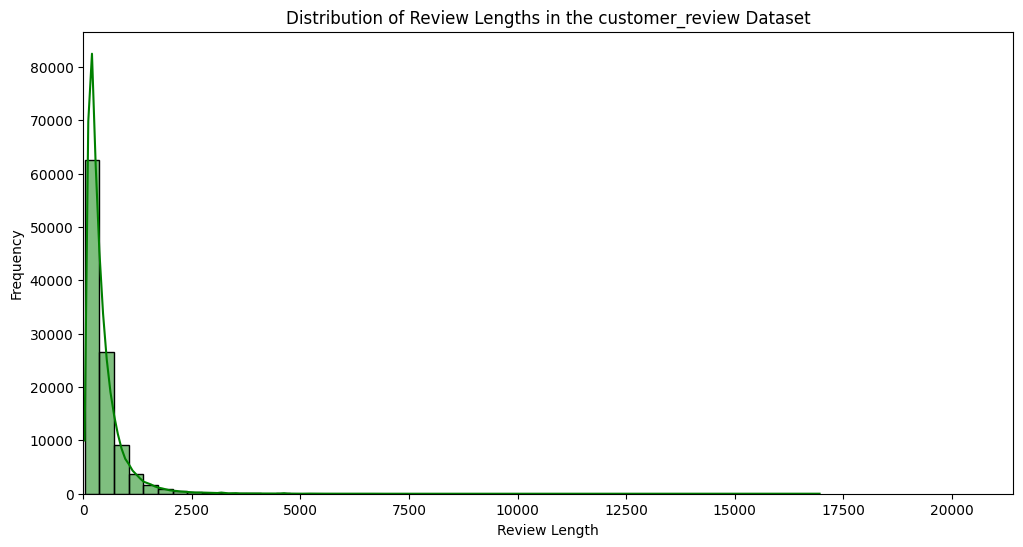

In [5]:
# Comment: Analyzing review length
tbl_labelled_review['review_length'] = tbl_labelled_review['review_text'].apply(len)
tbl_customer_review['review_length'] = tbl_customer_review['review_text'].apply(len)

# Define the maximum limit for the x-axis based on the maximum length of reviews
xlim_max = max(tbl_labelled_review['review_length'].max(), tbl_customer_review['review_length'].max())

# Visualizing the distribution of review lengths for the labelled_review dataset
plt.figure(figsize=(12, 6))
sns.histplot(tbl_labelled_review['review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths in the labelled_review Dataset')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.xlim(0, xlim_max)
plt.show()

# Visualizing the distribution of review lengths for the customer_review dataset
plt.figure(figsize=(12, 6))
sns.histplot(tbl_customer_review['review_length'], bins=50, kde=True, color='green')
plt.title('Distribution of Review Lengths in the customer_review Dataset')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.xlim(0, xlim_max)
plt.show()



The histogram above shows the distribution of review lengths in the labelled_review dataset. The distribution is notably right-skewed, indicating the presence of outliers with exceptionally long reviews. These outliers can significantly affect the mean review length and may require special consideration in analysis or preprocessing steps.


In [6]:
# Calculate percentiles for tbl_labelled_review
percentiles_labelled = np.arange(0, 1.05, 0.05)  # Percentiles from 0% to 100% in increments of 5%
percentile_values_labelled = tbl_labelled_review['review_length'].quantile(percentiles_labelled)

# Print the percentile table for tbl_labelled_review
print("Percentiles of Review Lengths for the labelled_review Dataset:")
print(percentile_values_labelled)

# Calculate percentiles for tbl_customer_review
percentiles_customer = np.arange(0, 1.05, 0.05)  # Using the same array of percentiles
percentile_values_customer = tbl_customer_review['review_length'].quantile(percentiles_customer)

# Print the percentile table for tbl_customer_review
print("\nPercentiles of Review Lengths for the customer_review Dataset:")
print(percentile_values_customer)


Percentiles of Review Lengths for the labelled_review Dataset:
0.00       12.0
0.05      110.0
0.10      127.0
0.15      143.0
0.20      161.0
0.25      179.0
0.30      199.0
0.35      221.0
0.40      245.0
0.45      271.0
0.50      300.0
0.55      333.0
0.60      370.0
0.65      413.0
0.70      463.0
0.75      525.0
0.80      604.0
0.85      714.0
0.90      875.0
0.95     1202.0
1.00    21409.0
Name: review_length, dtype: float64

Percentiles of Review Lengths for the customer_review Dataset:
0.00       33.0
0.05      111.0
0.10      128.0
0.15      145.0
0.20      163.0
0.25      182.0
0.30      203.0
0.35      226.0
0.40      250.0
0.45      278.0
0.50      307.0
0.55      340.0
0.60      378.0
0.65      423.0
0.70      474.0
0.75      537.0
0.80      618.0
0.85      726.0
0.90      890.0
0.95     1215.0
1.00    16952.0
Name: review_length, dtype: float64


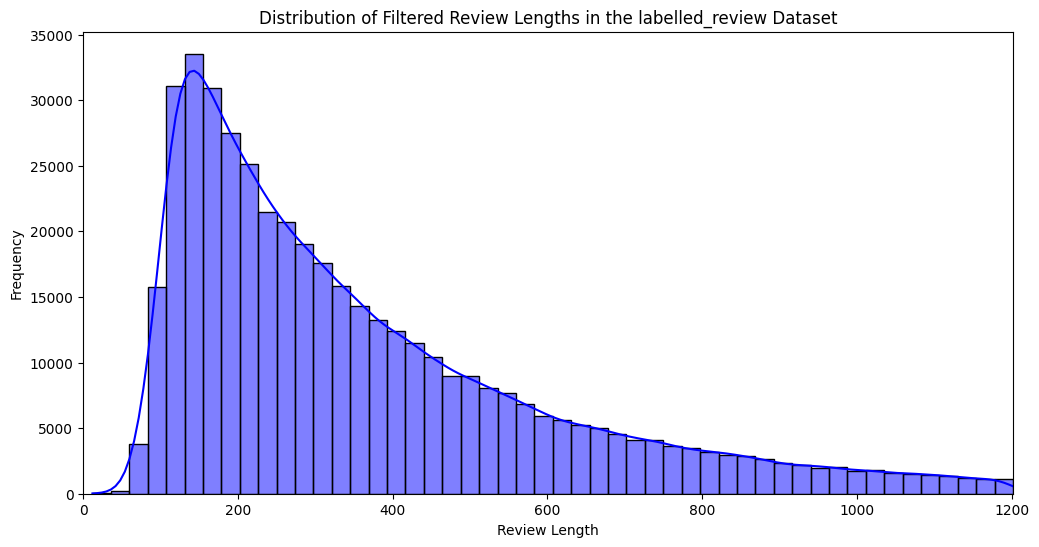

In [7]:
# Calculate the 95th percentile for the labelled_review dataset
percentile_95_labelled = tbl_labelled_review['review_length'].quantile(0.95)

# Overwrite the original table with the filtered version
tbl_labelled_review = tbl_labelled_review[tbl_labelled_review['review_length'] <= percentile_95_labelled]

# Visualize the updated distribution of review lengths
xlim_max = tbl_labelled_review['review_length'].max()

plt.figure(figsize=(12, 6))
sns.histplot(tbl_labelled_review['review_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Filtered Review Lengths in the labelled_review Dataset')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.xlim(0, xlim_max)
plt.show()


By removing reviews longer than the 95th percentile threshold of 1202 words, the distribution of review lengths in the labelled_review dataset has become more balanced. This step helps in reducing the skewness caused by extremely long reviews, facilitating more robust data analysis and modeling.


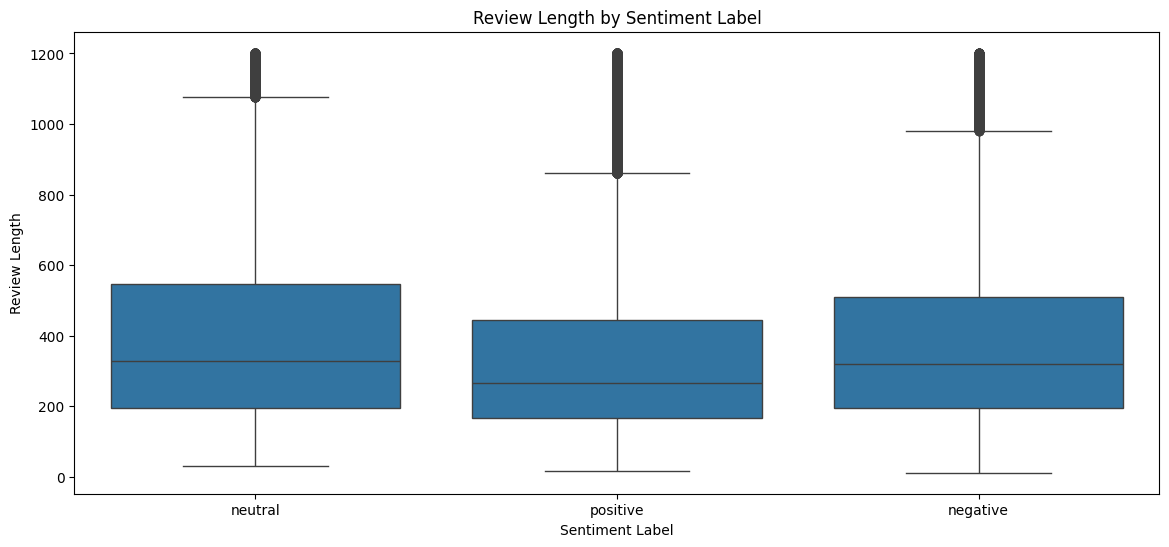

In [8]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=tbl_labelled_review, x='sentiment_label', y='review_length')
plt.title('Review Length by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Review Length')
plt.show()

After excluding reviews longer than the 95th percentile, the distribution of review lengths across different sentiment labels appears more balanced. The median review length for positive sentiments is slightly lower compared to neutral and negative sentiments, indicating that positive feedback tends to be more concise.


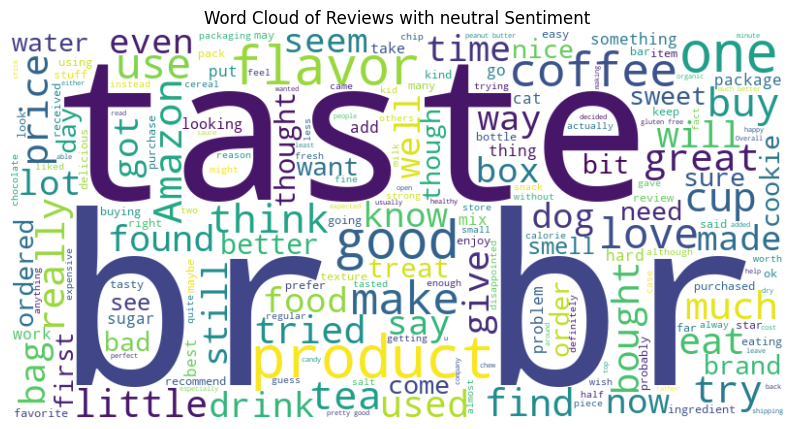

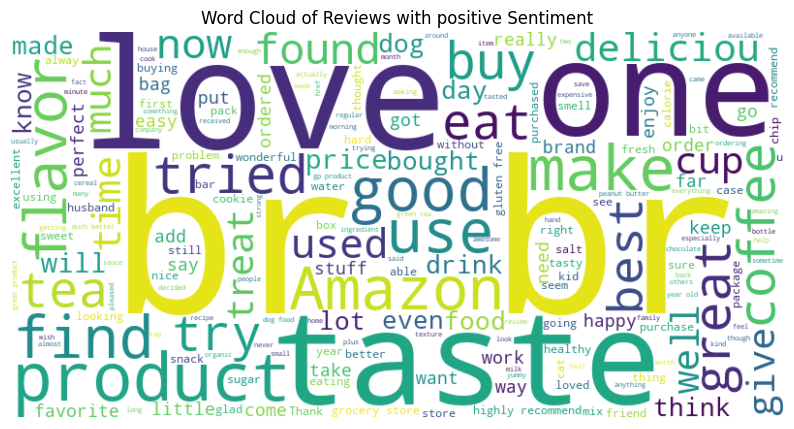

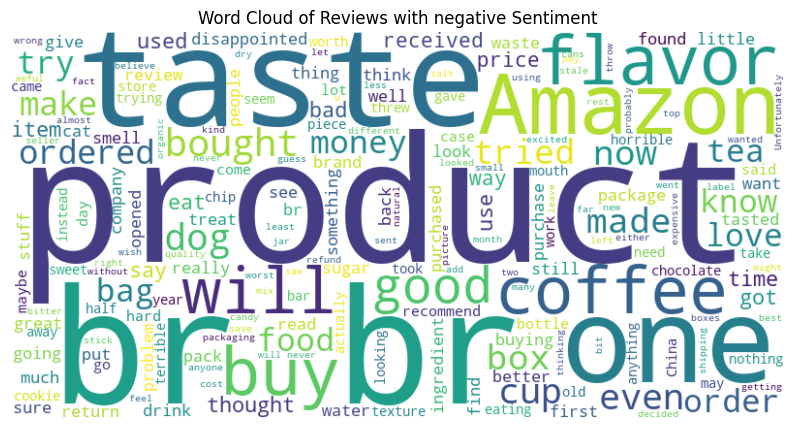

In [9]:
# Comment: Analysis of the most frequent words in reviews for each sentiment label
for sentiment in tbl_labelled_review['sentiment_label'].unique():
    reviews = ' '.join(tbl_labelled_review[tbl_labelled_review['sentiment_label'] == sentiment]['review_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Reviews with {sentiment} Sentiment')
    plt.show()


## Preprocessing

In [10]:

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Funzione per rimuovere numeri, punteggiatura e caratteri speciali
def clean_text(text):
    text = text.lower()  # Convertire il testo in minuscolo
    text = re.sub(r'\d+', '', text)  # Rimuovere i numeri
    text = text.translate(str.maketrans('', '', string.punctuation))  # Rimuovere la punteggiatura
    text = re.sub(r'\s+', ' ', text).strip()  # Rimuovere spazi extra e strip
    return text

# Funzione per tokenizzare il testo, rimuovere le stop words e lemmatizzare le parole
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Pulire il testo
    text = clean_text(text)
    # Tokenizzare
    words = word_tokenize(text)
    # Rimuovere le stop words e lemmatizzare
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


In [12]:
# Add progress bar with tqdm
tqdm.pandas()

# Apply preprocessing to the datasets
tbl_labelled_review['cleaned_review_text'] = tbl_labelled_review['review_text'].progress_apply(preprocess_text)
tbl_customer_review['cleaned_review_text'] = tbl_customer_review['review_text'].progress_apply(preprocess_text)

# Save the preprocessed data
tbl_labelled_review[['cleaned_review_text', 'sentiment_label']].to_csv(TBL_LABELLED_REVIEWS_PROCESSED_PATH, index=False)
tbl_customer_review[['review_id', 'customer_id', 'cleaned_review_text']].to_csv(TBL_CUSTOMER_REVIEWS_PROCESSED_PATH, index=False)

# Display the first rows of the cleaned datasets to verify the result
print("First rows of the tbl_labelled_review dataset after cleaning")
print(tbl_labelled_review[['review_text', 'cleaned_review_text']].head())

print("\nFirst rows of the tbl_customer_review dataset after cleaning")
print(tbl_customer_review[['review_text', 'cleaned_review_text']].head())


100%|██████████| 105710/105710 [02:03<00:00, 858.27it/s]


First rows of the tbl_labelled_review dataset after cleaning
                                         review_text  \
0  I'm no bitters expert but I bought it as a gif...   
1  these are probably great in the right drinks, ...   
2  I sent these to my dad for his bday and he sai...   
3  I purchased these as a gift for family member ...   
4  My wife bought me this sauce sampler for Chris...   

                                 cleaned_review_text  
0  im bitter expert bought gift friend surprised ...  
1  probably great right drink dont like old fashi...  
2  sent dad bday said really pretty good he hard ...  
3  purchased gift family member love bbq pork war...  
4  wife bought sauce sampler christmas knowing lo...  

First rows of the tbl_customer_review dataset after cleaning
                                         review_text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been arou

## Model Training

In [13]:
# Load the pre-processed data
tbl_labelled_review = pd.read_csv(TBL_LABELLED_REVIEWS_PROCESSED_PATH)

# Convert class labels to numerical values
label_encoder = LabelEncoder()
tbl_labelled_review['sentiment_label'] = label_encoder.fit_transform(tbl_labelled_review['sentiment_label'])

# Separate features and target
X = tbl_labelled_review['cleaned_review_text'].fillna('')
y = tbl_labelled_review['sentiment_label']

# Split the data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

# Check for NaN values in the data
print("NaN values in X_train:", X_train.isnull().sum())
print("NaN values in X_val:", X_val.isnull().sum())
print("NaN values in X_test:", X_test.isnull().sum())


NaN values in X_train: 0
NaN values in X_val: 0
NaN values in X_test: 0


### Logistic Regression

Logistic Regression - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.63      0.71      8009
           1       0.76      0.63      0.69     22973
           2       0.86      0.95      0.90     56947

    accuracy                           0.84     87929
   macro avg       0.81      0.74      0.77     87929
weighted avg       0.83      0.84      0.83     87929

Logistic Regression - Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.84     24026
           1       0.89      0.76      0.82     68920
           2       0.90      0.98      0.94    170841

    accuracy                           0.90    263787
   macro avg       0.91      0.83      0.87    263787
weighted avg       0.90      0.90      0.90    263787



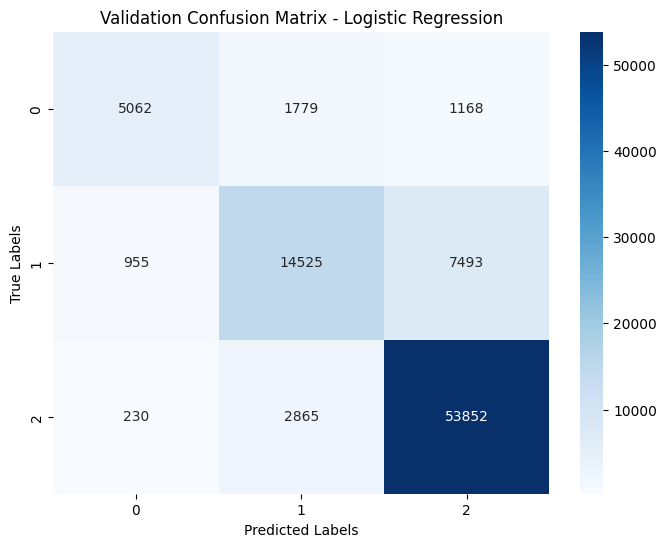

In [14]:
pipeline_logit = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(random_state=SEED))
])

# Addestrare il modello
pipeline_logit.fit(X_train, y_train)

# Prevedere i valori di validazione e di training
y_val_pred_logit = pipeline_logit.predict(X_val)
y_train_pred_logit = pipeline_logit.predict(X_train)

# Stampare il classification report per il validation set
print("Logistic Regression - Validation Classification Report:")
print(classification_report(y_val, y_val_pred_logit))

# Stampare il classification report per il training set
print("Logistic Regression - Training Classification Report:")
print(classification_report(y_train, y_train_pred_logit))

# Calcolare e stampare la confusion matrix per il validation set
conf_matrix_logit = confusion_matrix(y_val, y_val_pred_logit)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_logit, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix - Logistic Regression')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


### Linear SVM

SVM - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      8009
           1       0.78      0.69      0.74     22973
           2       0.88      0.95      0.91     56947

    accuracy                           0.86     87929
   macro avg       0.83      0.78      0.80     87929
weighted avg       0.85      0.86      0.85     87929

SVM - Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24026
           1       1.00      0.99      0.99     68920
           2       1.00      1.00      1.00    170841

    accuracy                           1.00    263787
   macro avg       1.00      1.00      1.00    263787
weighted avg       1.00      1.00      1.00    263787



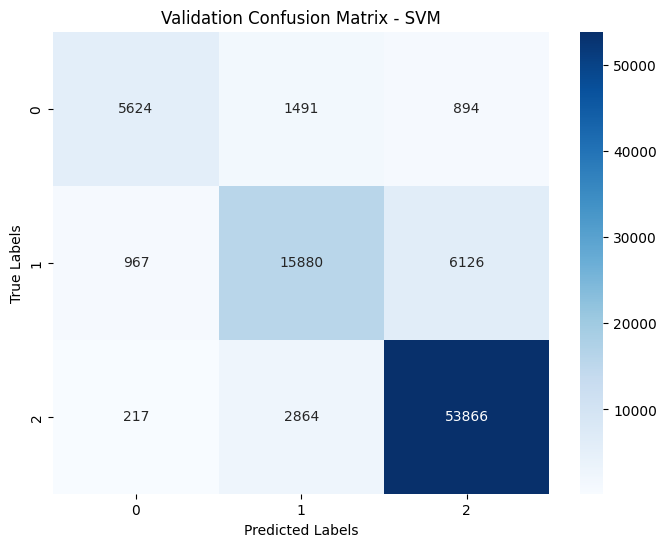

In [15]:
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LinearSVC(random_state=SEED))
])

# Addestrare il modello
pipeline_svm.fit(X_train, y_train)

# Prevedere i valori di validazione e di training
y_val_pred_svm = pipeline_svm.predict(X_val)
y_train_pred_svm = pipeline_svm.predict(X_train)

# Stampare il classification report per il validation set
print("SVM - Validation Classification Report:")
print(classification_report(y_val, y_val_pred_svm))

# Stampare il classification report per il training set
print("SVM - Training Classification Report:")
print(classification_report(y_train, y_train_pred_svm))

# Calcolare e stampare la confusion matrix per il validation set
conf_matrix_svm = confusion_matrix(y_val, y_val_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix - SVM')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


SVM - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.63      0.72      8009
           1       0.78      0.62      0.69     22973
           2       0.86      0.95      0.90     56947

    accuracy                           0.84     87929
   macro avg       0.82      0.74      0.77     87929
weighted avg       0.83      0.84      0.83     87929

SVM - Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     24026
           1       0.92      0.77      0.84     68920
           2       0.91      0.99      0.94    170841

    accuracy                           0.91    263787
   macro avg       0.93      0.86      0.89    263787
weighted avg       0.92      0.91      0.91    263787



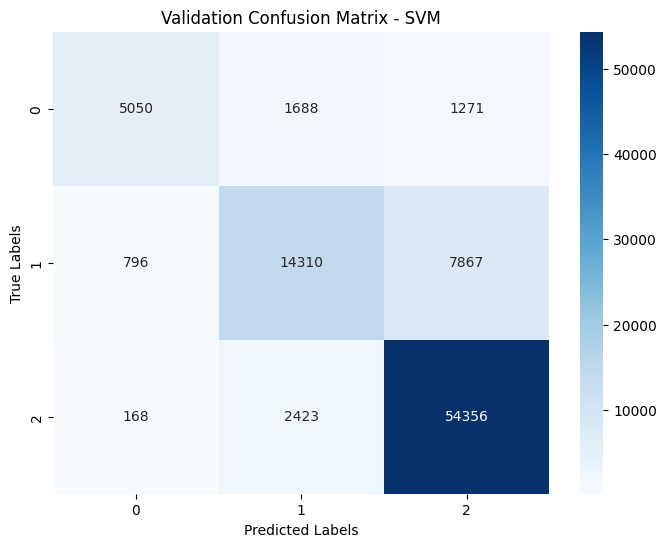

In [16]:

# Support Vector Machine (SVM)
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LinearSVC(random_state=SEED, C = 0.15))
])

# Addestrare il modello
pipeline_svm.fit(X_train, y_train)

# Prevedere i valori di validazione e di training
y_val_pred_svm = pipeline_svm.predict(X_val)
y_train_pred_svm = pipeline_svm.predict(X_train)

# Stampare il classification report per il validation set
print("SVM - Validation Classification Report:")
print(classification_report(y_val, y_val_pred_svm))

# Stampare il classification report per il training set
print("SVM - Training Classification Report:")
print(classification_report(y_train, y_train_pred_svm))

# Calcolare e stampare la confusion matrix per il validation set
conf_matrix_svm = confusion_matrix(y_val, y_val_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix - SVM')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


### Naive Bayes

Naive Bayes - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.01      0.02      8009
           1       0.98      0.07      0.14     22973
           2       0.66      1.00      0.80     56947

    accuracy                           0.67     87929
   macro avg       0.87      0.36      0.32     87929
weighted avg       0.77      0.67      0.55     87929

Naive Bayes - Training Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.01      0.03     24026
           1       0.98      0.12      0.22     68920
           2       0.67      1.00      0.80    170841

    accuracy                           0.68    263787
   macro avg       0.88      0.38      0.35    263787
weighted avg       0.78      0.68      0.58    263787



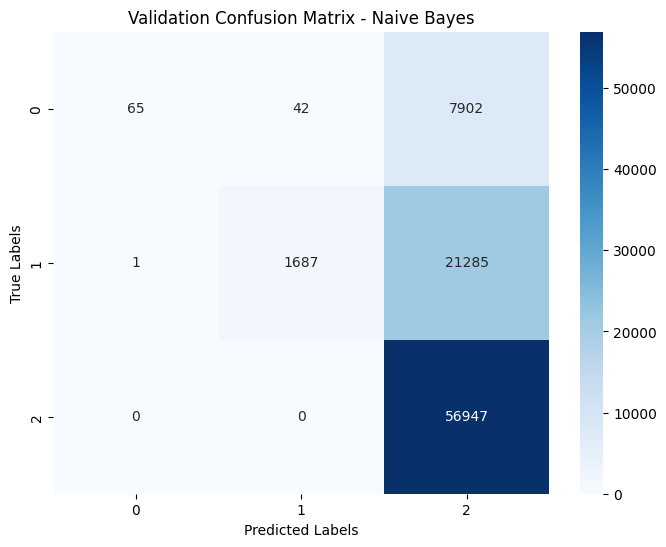

In [17]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', MultinomialNB())
])

# Addestrare il modello
pipeline_nb.fit(X_train, y_train)

# Prevedere i valori di validazione e di training
y_val_pred_nb = pipeline_nb.predict(X_val)
y_train_pred_nb = pipeline_nb.predict(X_train)

# Stampare il classification report per il validation set
print("Naive Bayes - Validation Classification Report:")
print(classification_report(y_val, y_val_pred_nb))

# Stampare il classification report per il training set
print("Naive Bayes - Training Classification Report:")
print(classification_report(y_train, y_train_pred_nb))

# Calcolare e stampare la confusion matrix per il validation set
conf_matrix_nb = confusion_matrix(y_val, y_val_pred_nb)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix - Naive Bayes')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


## Test Results

After evaluating the performance across various metrics, both Logistic Regression and SVM demonstrated comparable results. However, we opted for Logistic Regression as our model of choice. The key factor influencing this decision is the model's interpretability. Unlike SVM, Logistic Regression provides clear insights into the importance of different features. This interpretability is crucial as it facilitates the extraction of actionable insights, which are essential for developing targeted intervention strategies to improve our outcomes.


In [18]:

# Unire X_train e X_val
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Verifica delle dimensioni dei nuovi set
print(f"Dimensioni di X_train_full: {X_train_full.shape}")
print(f"Dimensioni di y_train_full: {y_train_full.shape}")


Dimensioni di X_train_full: (351716,)
Dimensioni di y_train_full: (351716,)


Logistic Regression - Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.65      0.72      8008
           1       0.75      0.64      0.69     22973
           2       0.87      0.94      0.90     56948

    accuracy                           0.84     87929
   macro avg       0.81      0.74      0.77     87929
weighted avg       0.83      0.84      0.83     87929



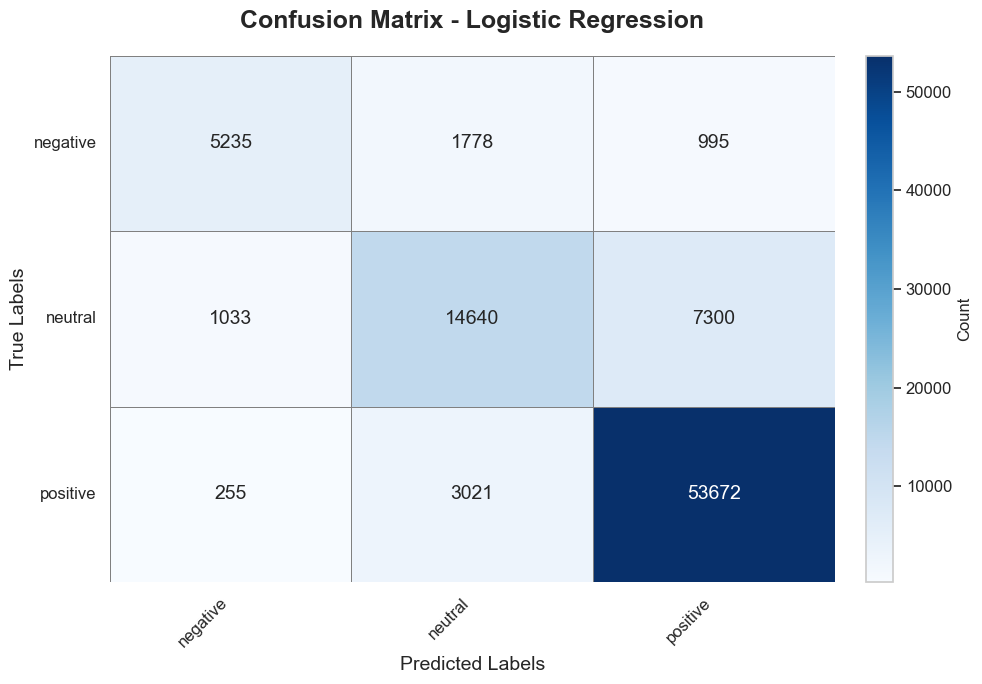

In [19]:
# Definire la pipeline con il miglior modello SVM e i parametri ottimizzati
pipeline_logit_final = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),  # I parametri del TF-IDF
    ('clf', LogisticRegression( random_state=SEED))  # Parametro C ottimizzat
])

# Addestrare il modello su X_train_full e y_train_full
pipeline_logit_final.fit(X_train_full, y_train_full)

# Prevedere i valori sul test set
y_test_pred = pipeline_logit_final.predict(X_test)

# Stampare il classification report per il test set
print("Logistic Regression - Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Calcolare e stampare la confusion matrix per il test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
# Creare la figura con dimensioni maggiori
plt.figure(figsize=(10, 7))

# Impostare uno stile pulito e professionale
sns.set(style="whitegrid")

# Creare l'heatmap
ax = sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, 
                 cbar=False, linewidths=0.5, linecolor='gray', annot_kws={"size": 14})

# Titolo e etichette con formattazione
plt.title('Confusion Matrix - Logistic Regression', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Migliorare la leggibilità delle etichette sull'asse x e y
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Aggiungere la barra colorata laterale per indicare i valori numerici
cbar = plt.colorbar(ax.collections[0], fraction=0.046, pad=0.04)
cbar.set_label('Count', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Aggiungere spaziatura per evitare sovrapposizioni di elementi grafici
plt.tight_layout()

# Mostrare il plot
plt.show()

In [20]:


# Definire la pipeline con il modello Logistic Regression
pipeline_logit_prod = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),  # I parametri del TF-IDF
    ('clf', LogisticRegression(random_state=SEED))  # Modello Logistic Regression
])

# Addestrare il modello su tutto il dataset X e y
pipeline_logit_prod.fit(X, y)


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(random_state=42))])

#### Save the model

In [21]:


# Creare la cartella 'models' se non esiste
if not os.path.exists('models'):
    os.makedirs('models')

# Salvare il modello addestrato nella cartella 'models'
joblib.dump(pipeline_logit_prod, BEST_MODEL_SENTIMENT_PATH)

print(f"Modello salvato in {BEST_MODEL_SENTIMENT_PATH}")

Modello salvato in c:\Users\Admin\Desktop\Universita\Magistrale\Marketing Analytics\temp\src\..\models\pipeline_logit_final.pkl


## Apply Best model on Customer Reviews

In [22]:
tbl_customer_review = pd.read_csv(TBL_CUSTOMER_REVIEWS_PROCESSED_PATH)
tbl_customer_review

,review_id,customer_id,cleaned_review_text
0,1,814256,bought several vitality canned dog food produc...
1,2,457475,product arrived labeled jumbo salted peanutsth...
2,3,104045,confection around century light pillowy citrus...
3,4,603662,looking secret ingredient robitussin believe f...
4,5,739314,great taffy great price wide assortment yummy ...
...,...,...,...
105705,140942,224091,lovelove keurig coffee maker husband life brea...
105706,140943,196666,supposed light roast coffee state extra bold l...
105707,140944,618226,always happy kcups particular box good made cu...
105708,140945,844918,ordered light roast coffee sent one box light ...


In [23]:

# Carica il modello dal file
model = joblib.load(BEST_MODEL_SENTIMENT_PATH)


In [24]:
# Prevedere le etichette per le recensioni
tbl_customer_review['sentiment_label_predicted'] = model.predict(tbl_customer_review['cleaned_review_text'])

# Mappare le etichette numeriche alle etichette testuali
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
tbl_customer_review['sentiment_label_predicted'] = tbl_customer_review['sentiment_label_predicted'].map(label_map)


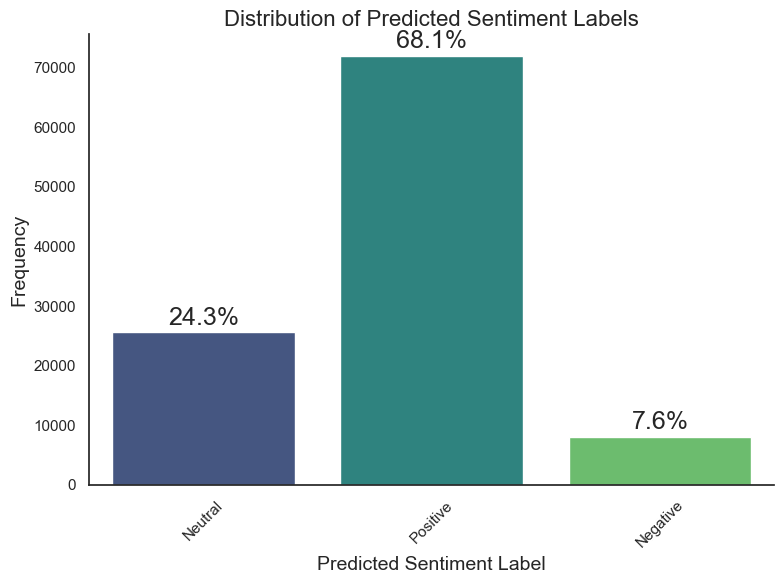

In [25]:


# Impostazioni del grafico
sns.set(style="white")

# Creare il barplot
# Creare il barplot con ordine specifico
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='sentiment_label_predicted', data=tbl_customer_review, palette='viridis',
                   order=["Neutral", "Positive", "Negative"])  # Ordine specifico delle categorie
plt.title('Distribution of Predicted Sentiment Labels', fontsize=16)
plt.xlabel('Predicted Sentiment Label', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)  # Ruota le etichette sull'asse x per una migliore visualizzazione

# Calcola il totale delle osservazioni per calcolare le percentuali
total = len(tbl_customer_review['sentiment_label_predicted'])

# Aggiungere le annotazioni con il conteggio esatto e la percentuale su ogni barra
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=18)

# Mostra il grafico
sns.despine()

plt.tight_layout()
plt.show()

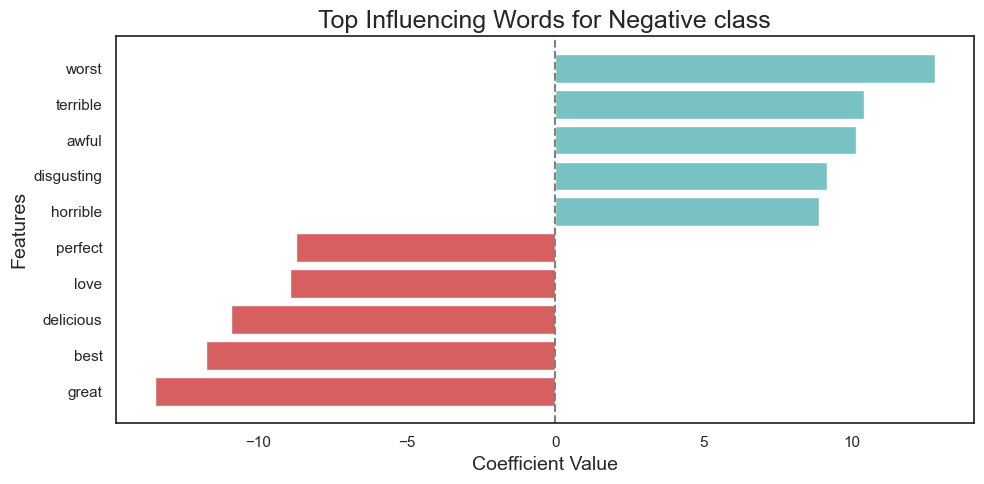

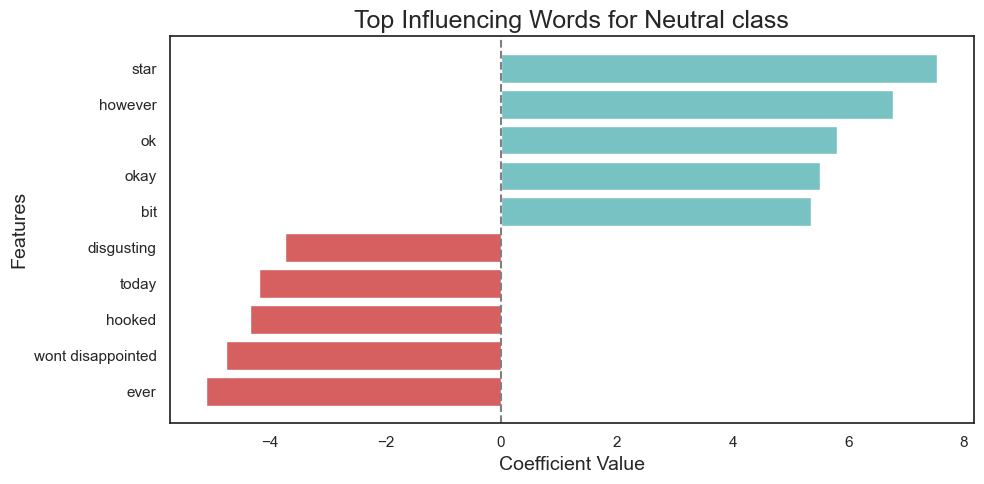

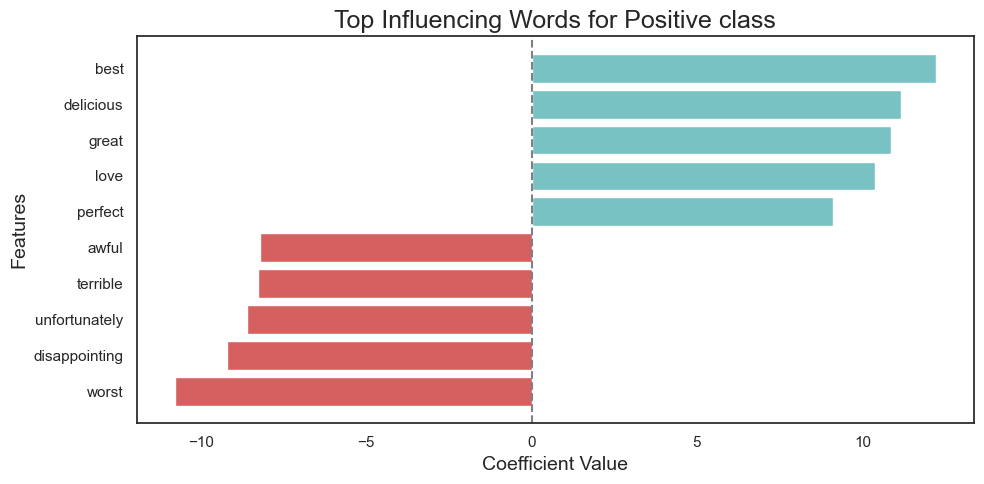

In [26]:

# Ottenere i nomi delle feature dal TfidfVectorizer
feature_names = model.named_steps['tfidf'].get_feature_names_out()

# Ottenere i coefficienti dal modello Logistic Regression
coefficients = model.named_steps['clf'].coef_

# Se il modello è multicategoria, 'coefficients' sarà una matrice (n_classes, n_features)
for i, class_label in enumerate(model.named_steps['clf'].classes_):
    # Ordinare i coefficienti per questa classe
    sorted_coef_index = coefficients[i].argsort()

    # Le 3 parole più negative (peso negativo più alto)
    smallest = sorted_coef_index[:5]
    # Le 3 parole più positive (peso positivo più alto)
    largest = sorted_coef_index[-5:]

    # Preparare i dati per il plot
    top_features = np.hstack([smallest, largest])
    top_coefficients = coefficients[i][top_features]
    top_colors = ['#d65f5f' if c < 0 else '#79c2c3' for c in top_coefficients]  # Red for negative, Greenish for positive

    # Creazione del plot
    plt.figure(figsize=(10, 5))
    bars = plt.barh(feature_names[top_features], top_coefficients, color=top_colors)
    plt.axvline(x=0, color='gray', linestyle='--')  # Linea verticale a zero per distinzione
    plt.title(f'Top Influencing Words for {label_map[class_label]} class', fontsize=18)
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)



    plt.tight_layout()
    plt.show()



The top influencing words for each sentiment class, as illustrated by the feature importance graphs, provide valuable insights into the factors that drive sentiment classification:

- **Negative Sentiment:** Words like "worst" and "terrible" strongly influence the negative sentiment, highlighting typical expressions of dissatisfaction in customer feedback.

- **Neutral Sentiment:** Neutral terms such as "however" and "okay" suggest a balanced or indifferent customer opinion, lacking strong positive or negative emotions.

- **Positive Sentiment:** Conversely, positive sentiment is predominantly driven by words like "best" and "delicious", indicating strong satisfaction and enjoyment.

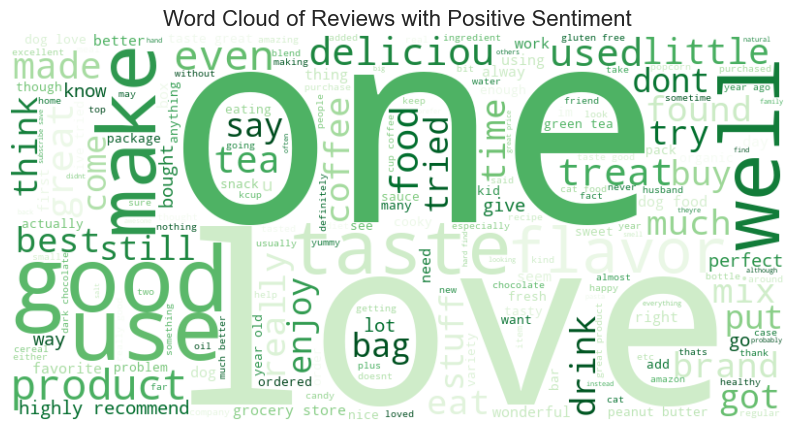

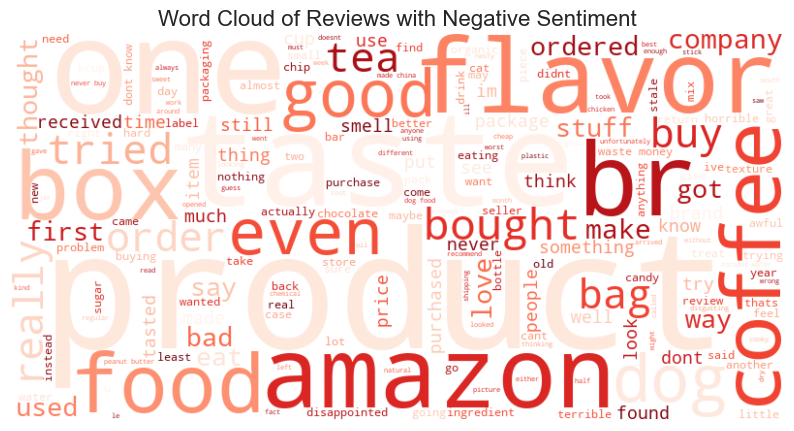

In [27]:


# Riempire i valori NaN con stringhe vuote
tbl_customer_review['cleaned_review_text'] = tbl_customer_review['cleaned_review_text'].fillna('')

# Definire i colori per ciascun sentiment
color_map = {
    'Positive': 'Greens',
    'Negative': 'Reds'
}

# Imposta il seed per la generazione del word cloud

# Commento: Analisi delle parole più frequenti nelle recensioni per sentiment "positive" e "negative"
for sentiment in ['Positive', 'Negative']:
    reviews = ' '.join(tbl_customer_review[tbl_customer_review['sentiment_label_predicted'] == sentiment]['cleaned_review_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map[sentiment], random_state=SEED).generate(reviews)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Reviews with {sentiment.capitalize()} Sentiment', fontsize=16)
    plt.show()


The word clouds present a vivid depiction of the most frequently used words in customer reviews, categorized by the sentiment labels that our model assigned. In reviews with positive sentiment, prevalent words like "love," "delicious," and "perfect" highlight the attributes customers appreciate most, suggesting strong satisfaction. Conversely, for reviews labeled with negative sentiment, prominent words such as "disappointed," "waste money," and "horrible" pinpoint the main issues customers faced, offering clear directions for product and service enhancements.


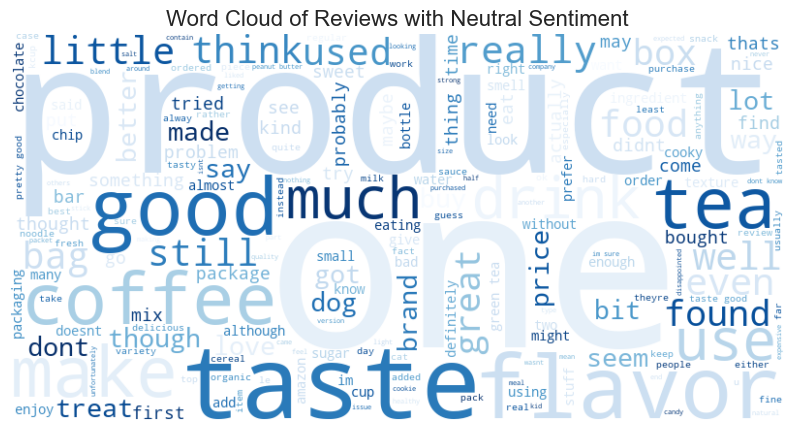

In [28]:
# Fill NaN values with empty strings
tbl_customer_review['cleaned_review_text'] = tbl_customer_review['cleaned_review_text'].fillna('')

# Define colors for each sentiment
color_map = {
    'Positive': 'Greens',
    'Negative': 'Reds',
    'Neutral': 'Blues'  # Choose a neutral color for neutral sentiment
}

# Set seed for word cloud generation

# Analyze the most frequent words for positive, negative, and neutral sentiments
for sentiment in ['Neutral']:
    reviews = ' '.join(tbl_customer_review[tbl_customer_review['sentiment_label_predicted'] == sentiment]['cleaned_review_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map[sentiment], random_state=SEED).generate(reviews)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Reviews with {sentiment.capitalize()} Sentiment', fontsize=16)
    plt.show()


The word cloud for reviews with neutral sentiment shows a more ambiguous mix of terms compared to the clearly positive or negative keywords found in the other sentiment categories. Words like "good," "really," and "much" appear alongside neutral terms such as "still," "bit," and "though," indicating a more balanced or mixed sentiment that does not strongly lean towards either extreme.


## Key Insights and Recommendations


### Reward and Amplify Loyal Customers

Since the majority of customer feedback (68.1%) is positive, launch a campaign focused on rewarding and amplifying these loyal customers. Offer personalized discounts or exclusive offers to encourage them to continue their positive relationship with the brand. This could further strengthen brand loyalty and promote positive word-of-mouth

### Convert Neutral Customers into Promoters

Addressing the 24.3% of feedback that is neutral, we suggest implementing follow-up surveys or targeted communications to convert neutral customers into promoters. This approach aims to shift their neutral stance to a more positive one, enhancing overall customer satisfaction.

### Resolve Negative Feedback to Improve Retention 

Given that negative reviews constitute 7.6% of the feedback, it is crucial to engage these customers directly. By designing specialized customer service campaigns that offer resolutions or incentives, we aim to improve customer satisfaction and retention significantly.
